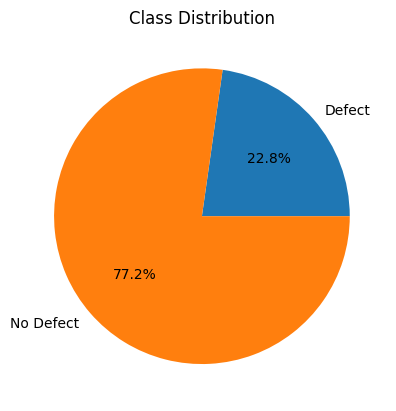

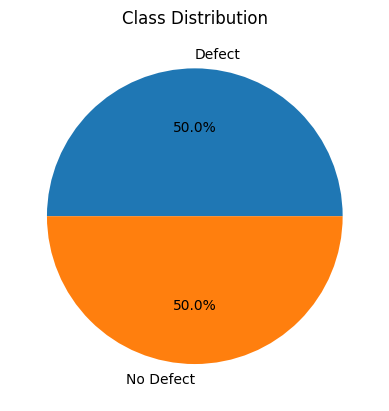

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


def split_dataset(source_folder, output_root_folder):
    # creating output folders if they don't exist
    target_defect_folder = os.path.join(output_root_folder, "Defect_images")
    target_no_defect_folder = os.path.join(output_root_folder, "NODefect_images")
    os.makedirs(target_defect_folder, exist_ok=True)
    os.makedirs(target_no_defect_folder, exist_ok=True)

    # split defect images
    defect_images_folder = os.path.join(source_folder, "Defect_images")

    # copy defect images
    for file_name in os.listdir(defect_images_folder):
        source_path = os.path.join(defect_images_folder, file_name)
        target_path = os.path.join(target_defect_folder, file_name)
        shutil.copy2(source_path, target_path)

    # copy non-defect images
    no_defect_images_folder = os.path.join(source_folder, "NODefect_images")
    for subfolder_name in os.listdir(no_defect_images_folder):
        subfolder_path = os.path.join(no_defect_images_folder, subfolder_name)
        if os.path.isdir(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                source_path = os.path.join(subfolder_path, file_name)
                target_path = os.path.join(target_no_defect_folder, file_name)
                shutil.copy2(source_path, target_path)

# source folder and the output root directory
dataset_folder = "/content/drive/MyDrive/textile"
output_root_folder = "/content/drive/MyDrive/output feed"


split_dataset(dataset_folder, output_root_folder)





def preprocess_data(defect_folder, nodefect_folder):
    defect_images = load_images_from_folder(defect_folder)
    nodefect_images = load_images_from_folder(nodefect_folder)

    # augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2]
    )

    augmented_images = []
    for img in defect_images:
        augmented_images.append(img)
        img = np.expand_dims(img, axis=0)
        it = datagen.flow(img, batch_size=1)
        for _ in range(4):  # 4 augmented images per original image
            batch = it.next()
            augmented_img = batch[0].astype('uint8')
            augmented_images.append(augmented_img)

    # combine defect and non-defect images
    X = np.concatenate((augmented_images, nodefect_images))
    y = np.concatenate((np.ones(len(augmented_images)), np.zeros(len(nodefect_images))))

    # shuffle
    X, y = shuffle(X, y, random_state=57)

    return X, y

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images



def plot_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    labels = ['Defect', 'No Defect']
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.show()




defect_folder = os.path.join(output_root_folder, "Defect_images")
nodefect_folder = os.path.join(output_root_folder, "NODefect_images")

X, y = preprocess_data(defect_folder, nodefect_folder)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)


plot_class_distribution(y_train)



smote = SMOTE(random_state=57)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train)

X_train = X_train.reshape(-1, 224, 224, 3)

plot_class_distribution(y_train)

In [ ]:
from tensorflow.keras.layers import LSTM

# Reshape X_train and X_test for LSTM input
X_train_LSTM = X_train.reshape(-1, X_train.shape[1], X_train.shape[2] * X_train.shape[3])
X_test_LSTM = X_test.reshape(-1, X_test.shape[1], X_test.shape[2] * X_test.shape[3])

# Define early stopping criteria for LSTM
early_stopping_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

# Create an LSTM model
lstm_model = tf.keras.Sequential([
    LSTM(128, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

# Train the LSTM model
history_lstm = lstm_model.fit(X_train_LSTM, y_train, epochs=10, batch_size=50,
                              validation_data=(X_test_LSTM, y_test), callbacks=[early_stopping_lstm])

# Evaluate the LSTM model
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_LSTM, y_test)
print("LSTM Test Accuracy:", test_acc_lstm)


Epoch 1/10
17/17 [==============================] - 16s 833ms/step - loss: 0.6934 - accuracy: 0.5278 - val_loss: 0.6797 - val_accuracy: 0.7556
Epoch 2/10
17/17 [==============================] - 13s 783ms/step - loss: 0.6814 - accuracy: 0.5809 - val_loss: 0.6921 - val_accuracy: 0.4963
Epoch 3/10
17/17 [==============================] - 12s 704ms/step - loss: 0.6805 - accuracy: 0.5785 - val_loss: 0.7677 - val_accuracy: 0.2593
Epoch 4/10
17/17 [==============================] - 12s 671ms/step - loss: 0.6643 - accuracy: 0.6014 - val_loss: 0.5557 - val_accuracy: 0.8593
Epoch 5/10
17/17 [==============================] - 13s 788ms/step - loss: 0.6792 - accuracy: 0.5700 - val_loss: 0.6680 - val_accuracy: 0.7111
Epoch 6/10
17/17 [==============================] - 13s 751ms/step - loss: 0.6374 - accuracy: 0.7041 - val_loss: 0.6046 - val_accuracy: 0.6889
Epoch 7/10
17/17 [==============================] - 12s 670ms/step - loss: 0.6302 - accuracy: 0.6292 - val_loss: 0.6193 - val_accuracy: 0.8519